# What's fit.py doing? The fitting procedure in detail

To give further insight into the fitting process in <font color=green>Frankenstein</font> (`frank`) and how you can modify it, here we'll use the code as a module and perform the same fit that's in the [Quickstart](../quickstart.rst), just in more detail.

So we'll keep using the DSHARP continuum observations of AS 209 ([Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract)) as the input dataset, and frank will reconstruct the disc's 1D radial brightness profile by nonparametrically fitting the real component of the visibility distribution. 

Specifically frank will perform 4 steps in the fit, which we'll break into distinct calls here (these are the steps taken in `fit.py`): 

1. Parse the *.json* parameter file and read in the data (UVTable); 

2. Determine the disc geometry (inclination, position angle and phase offset), then deproject the visibilities;

3. Fit the deprojected visibilities with a Gaussian process (it'll take ~50 sec for this dataset) to yield a brightness profile;

4. Save the fit results and diagnostic figures. We'll also supply a CLEAN brightness profile for the disc as well as the synthesized CLEAN beam parameters, in order to compare the frank fit to the CLEAN fit by:

    - Convolving the fitted frank brightness profile with the synthesized beam to compare to the CLEAN profile and
    
    - Taking the discrete Hankel transform of the CLEAN profile to compare to the frank visibility domain fit.
    
Let's walk through these.

## 1. Read in the parameter values and data

As in the second example in the [Quickstart](../quickstart.rst) - where we use frank as a module - we'll import the internal classes [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) and [FitGeometryGaussian](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.FitGeometryGaussian) directly, in order to demonstrate their usage. Just note that `fit.py` uses the wrapper functions `deproject_disc` and `perform_fit` to call these, and more generally uses wrapper functions to do everything that we'll walk through more verbosely here.

In [1]:
%matplotlib inline

import numpy as np

from frank.geometry import FitGeometryGaussian, SourceGeometry 
from frank.radial_fitters import FrankFitter
from frank.fit import load_default_parameters
from frank.utilities import convolve_profile 
from frank.make_figs import make_deprojection_fig, make_clean_comparison_fig
from frank.io import save_fit

Using a UVTable extracted from an MSTable (see [xx](xx.xx) for how to do this) and the default parameter file `default_parameters.json`, let's read both in.

In [2]:
model = load_default_parameters()

as209_dat = np.load('AS209_continuum.npz')
u, v, vis, weights = [as209_dat[k] for k in ['u', 'v', 'V', 'weights']]

## 2. Determinine the disc geometry and deproject the visibilities
<a id='determine_geometry'></a>

Before fitting the radial brightness profile, we need to determine the disc's geometry (inclination, position angle and phase center) in order to deproject the visibilities (recall that frank, fitting in 1D, assumes an axisymmetric source).
To do this we pass an object specifying how the geometry is determined to the [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) class.

frank has two classes for this: [FixedGeometry](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.FixedGeometry) just takes a geometry you provide, while [FitGeometryGaussian](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.FitGeometryGaussian) determines the geometry by fitting a 2D Gaussian directly to the visibilities. Note that this is a pretty coarse appraoch to fitting the geometry; we're working to extend the code to fit the geometry and brightness profile simultaneously. You can also supply your own geometry fitting routine (see [Sec.2.1](#own_geometry)).

For [FitGeometryGaussian](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.FitGeometryGaussian) you can also choose to provide a known phase center if you just want to fit for the inclination and PA. But let's assume we don't know any of the disc's geometry parameters, and so fit for them all.

In [3]:
geom = FitGeometryGaussian()
geom.fit(u, v, vis, weights)

print('Fitted geometry: inc  = {:.2f} deg,\n\t\t PA   = {:.2f} deg,\n\t\t' 
      ' dRA  = {:.2e} mas,\n\t\t dDec = {:.2e} mas'.format(geom.inc, geom.PA,
                                                           geom.dRA*1e3,
                                                           geom.dDec*1e3))

Fitted geometry: inc  = -33.93 deg,
		 PA   = 86.47 deg,
		 dRA  = -8.63e-01 mas,
		 dDec = 2.29e-01 mas


And let's plot the deprojected (u, v) coordinates and visibilities, just to verify that our correction had a reasonable effect. Note that `FrankFitter` (which we'll use below) deprojects the visibilities as a step in the fit; here we'll just redundantly deproject them to make the plot.

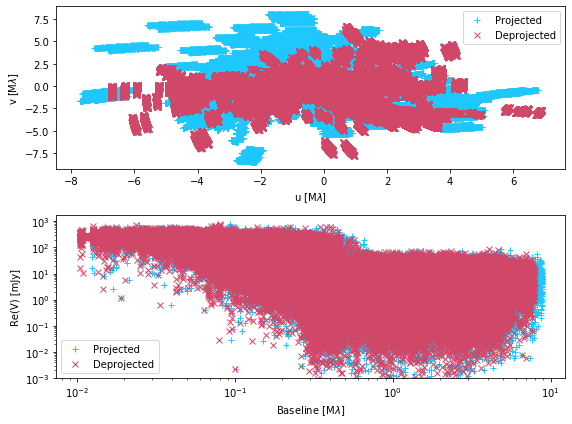

In [4]:
# Deproject the visibilities by the fitted geometry
up, vp, visp = geom.apply_correction(u,v, vis)

make_deprojection_fig(u, v, up, vp, vis, visp, force_style=False);

### 2.1 Adding your own geometry fit routine 
<a id='own_geometry'></a>

You can extend frank's geometry fitting capabilities with your own routines by writing a class that inherits from the [SourceGeometry](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry) base class. This base class provides the interface used by frank to deproject the visibilities, but you do need to implement your own [fit()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.fit) method. This method will be called internally by [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) to determine the geometry.

The [fit()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.fit) method should set the attributes `_inc`,  `_PA`, `_dRA`, and `_dDec` -- in respective units of [deg], [deg], [arcsec], [arcsec] -- that are used by the
[apply_correction()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.apply_correction),
[undo_correction()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.undo_correction),
[deproject()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.deproject),
and
[reproject()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.reproject) methods.

## 3. Fit the deprojected visibilities for the brightness profile
<a id='fit_vis'></a>

Ok, so we have the deprojected visibilities...let's fit 'em!

Objects used to perform a fit are in the [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) class. In addition to the the `geom` object detailed in [Sec.2](#determine_geometry), five hyperparameters affect the fit: `Rmax` and `N`, which set the disc radius out to which the fit is performed and the number of collocation points used in the fit; and `alpha`, `p_0` and `weights_smooth`, the hyperprior parameters on the reconstructed power spectrum prior. See [this tutorial](./xx) for an explanation and interpretation of these five hyperparameters, and [this tutorial](./prior_sensitivity.ipynb) for a demonstration of how to test their effect on a given fit.

frank performs a fit with the [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) class' [fit()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter.fit) function. Let's use this with the `geom` object we generated above using the published geometry values, `Rmax = 1.6"` appropriate for AS 209, `N = 250` to ensure we resolve narrow features in the brightness profile, and the default values `p_0 = 1e-15`, `alpha = 1.05` and `weights_smooth = 1e-4`. Recall that we'll only fit the real component of the visibilities, as frank is assuming an axisymmetric source that has zero imaginary component.

In [5]:
Rmax, N, alpha, weights_smooth = 1.6, 250, 1.05, 1e-4

# Initialze the FrankFitter class
FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth=weights_smooth)

# Fit the data, returning the maximum a posteriori solution object
sol = FF.fit(u, v, vis, weights)

Once the fit is complete, the brightness profile's best fit parameters are returned and stored in the [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) class' [MAP_solution](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter.MAP_solution) object (we called it `sol`). This provides:

- the posterior [mean](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.mean) and [covariance](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.covariance) for the reconstructed brightness profile; 
- the fit's radius points [r](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.r) and corresponding frequency points [q](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.q); 
- methods to compute the best fit model's visibilities at given (u, v) coordinates in either the sky plane with [predict](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.predict) or the deprojected plane with [predict_deprojected](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.predict_deprojected);
- and a method to evaluate the best fit model's [log_likelihood](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.log_likelihood).

Additionally the `FrankFitter` object we created (we called it `FF`) contains the power spectrum's best fit parameters:
- the maximum a posteriori power spectrum mean ([MAP_spectrum](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter.MAP_spectrum)) and covariance ([MAP_spectrum_covariance](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter.MAP_spectrum_covariance)).



## 4. Save the results and generate plots

We could now save the fit results, including the `sol` object, with `save_fit(u, v, vis, weights, sol, prefix='AS209_continuum')`. We could also produce a full diagnostic figure and/or simplified figure of the fit. But since we've already done all this in the [Quickstart](../quickstart.rst), let's instead use the `sol` object to make a figure comparing the frank fitted brightness profile to the published CLEAN image-extracted profile ([Huang et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..42H/abstract)).

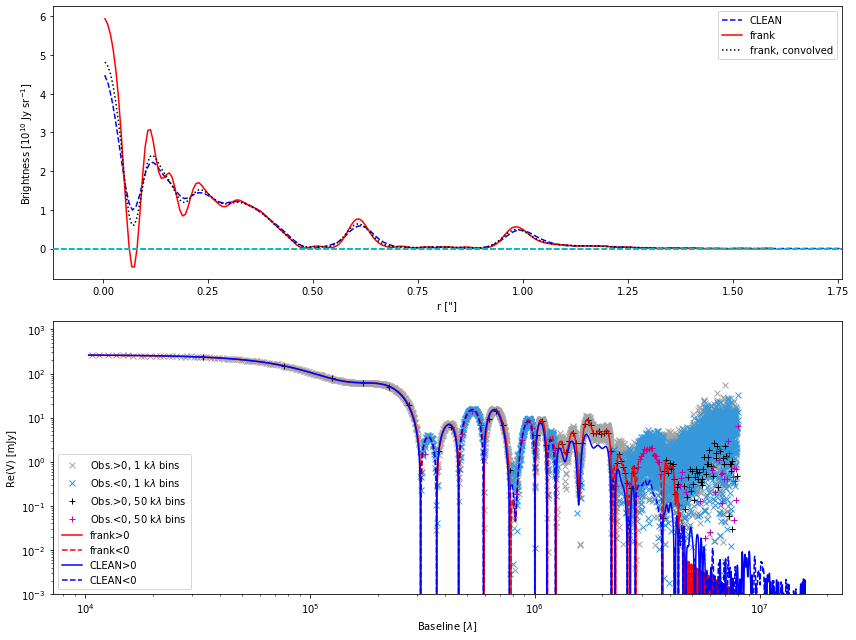

In [6]:
# Load the CLEAN radial profile for AS 209 from Huang et al. 2018
r_clean, i_clean = np.genfromtxt('./AS209_clean_profile.dat')

# Using the same disc geometry parameters as above (the published values)
# and the CLEAN beam parameters from CASA (`imhead` of the published .fits file),
# convolve the frank profile with the CLEAN beam
bmaj, bmin, beam_pa = 0.03883, 0.03818, 85.82243
mean_convolved = convolve_profile(sol.r, sol.mean, geom.inc, geom.PA, bmaj, bmin, beam_pa)

make_clean_comparison_fig(u, v, vis, weights, sol, mean_convolved, r_clean, i_clean,
                          bin_widths=[1e3, 5e4], force_style=False);

So the frank profile, when convolved with the CLEAN beam, is pretty similar to the CLEAN profile. This is one indication that the frank profile is correctly identifying sub-beam structure. 

The discrete Hankel transform (DHT) of the CLEAN profile, relative to the frank visibility fit, is low beyond $\approx 1\times 10^6 \lambda$ primarily because of beam convolution. This is another indication that the frank profile is  finding real sub-beam structure.